# Exploring of the LIAR dataset

In this jupyter notebook, the LIAR dataset from Wang 2017 (http://arxiv.org/abs/1705.00648) is explored. It is a dataset related to factual verification (final step of fake news detection) that is based on verdicts from PolitiFact.

This notebook looks at the distribution of the data, both in terms of words used, speakers, and verdicts.

## Import of modules

First, relevant Pyton modules are imported

In [4]:
%load_ext autoreload
%autoreload

from liar_utils import load_liar_dataset, LIARLabel, label_to_name
import seaborn as sns
from plotting_utils import dataframe_to_text, show_word_cloud, show_bar_plot
import os
import matplotlib.pyplot as plt
import pandas as pd

sns.set_theme()
check_worthiness = pd.read_csv("../results/LIAR/checkworthiness.csv", index_col=0)
display(check_worthiness.head())
data = load_liar_dataset("../data/LIAR")
data.head()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,label,statement,check_worthiness
id,,,
2635.json,1,Says the Annies List political group supports ...,1.0
10540.json,3,When did the decline of coal start? It started...,1.0
324.json,4,"Hillary Clinton agrees with John McCain ""by vo...",1.0
1123.json,1,Health care reform legislation is likely to ma...,1.0
9028.json,3,The economic turnaround started at the end of ...,0.0


,label,statement
id,,
2635.json,1,Says the Annies List political group supports ...
10540.json,3,When did the decline of coal start? It started...
324.json,4,"Hillary Clinton agrees with John McCain ""by vo..."
1123.json,1,Health care reform legislation is likely to ma...
9028.json,3,The economic turnaround started at the end of ...


## Wordclouds

Generate one wordcloud for the whole dataset, and one for each label. Also generates word clouds for check-worthy and non check-worthy claims according to the predictions from a fine-tuned LLM.

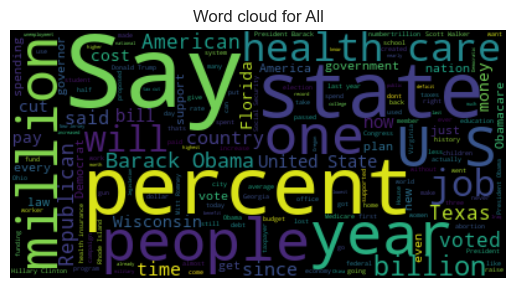

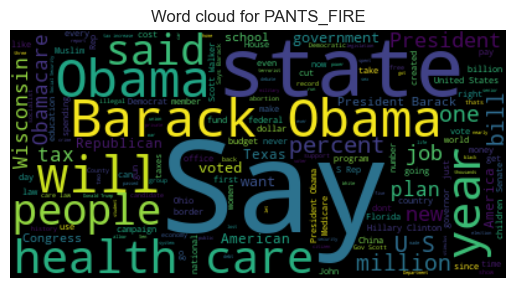

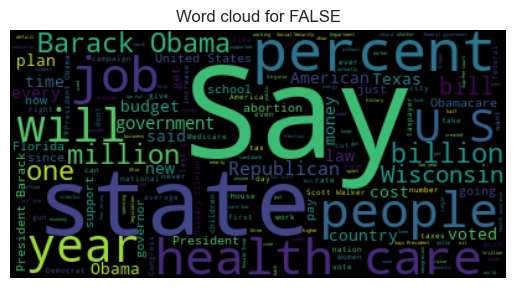

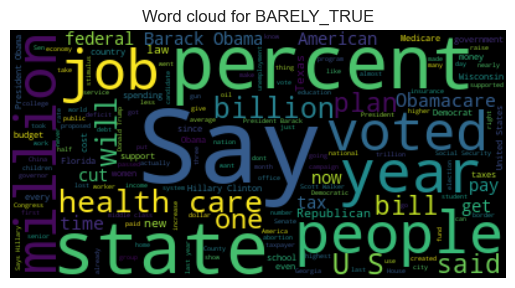

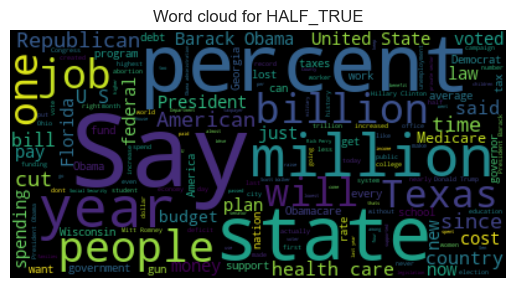

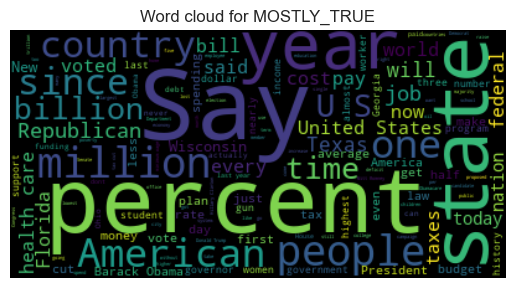

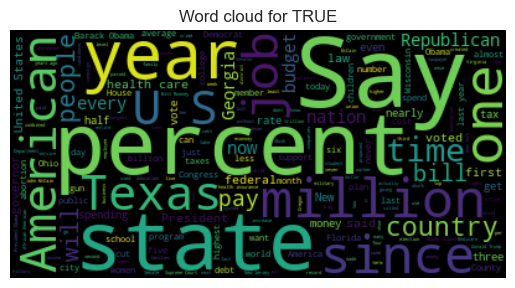

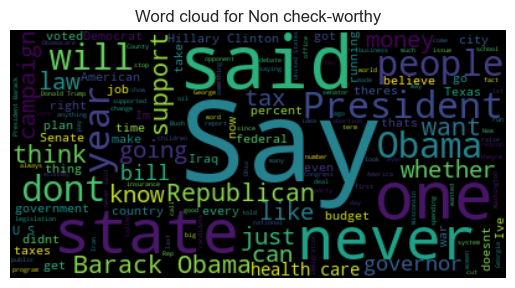

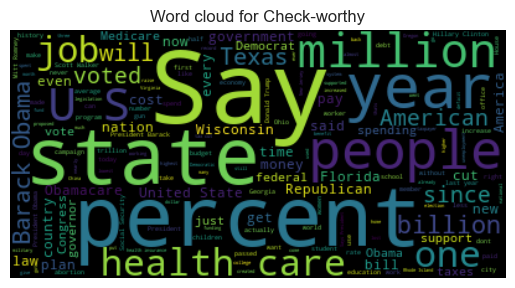

In [3]:
%autoreload
titles = ["All", *LIARLabel]
os.makedirs("../figures/liar/wordclouds", exist_ok=True)
for title in titles:
    if title == "All":
        text = dataframe_to_text(data, ["statement"])
    else:
        filtered_data = data[data["label"] == title.value]
        text = dataframe_to_text(filtered_data, ["statement"])
    title = f"Word cloud for {title.name if title != 'All' else 'All'}"
    save_path = f"../figures/liar/wordclouds/{title}.png"
    show_word_cloud(text, title, file_path=save_path)
check_worthiness_titles = ["Non check-worthy", "Check-worthy"]
check_worthiness_scores = [0, 1]
for score, title in zip(check_worthiness_scores, check_worthiness_titles):
    filtered_data = check_worthiness[check_worthiness["check_worthiness"] == score]
    text = dataframe_to_text(filtered_data, ["statement"])
    title = f"Word cloud for {title}"
    save_path = f"../figures/liar/wordclouds/{title}.png"
    show_word_cloud(text, title, file_path=save_path)

## Label distributon

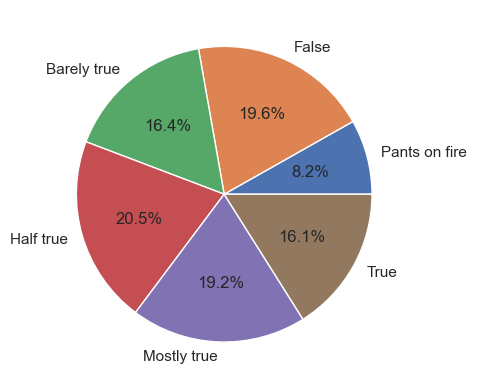

In [38]:
plt.pie(
    [data[data["label"] == label.value].shape[0] for label in LIARLabel],
    labels=[label_to_name(label) for label in LIARLabel],
    autopct="%.1f%%",
)
plt.savefig("../figures/liar/total_distribution.pdf")
plt.show()


## Key words for check-worthiness

Investigating certain keywords that could help explain why claims of certain labels are more likely to be labeled check-worthy

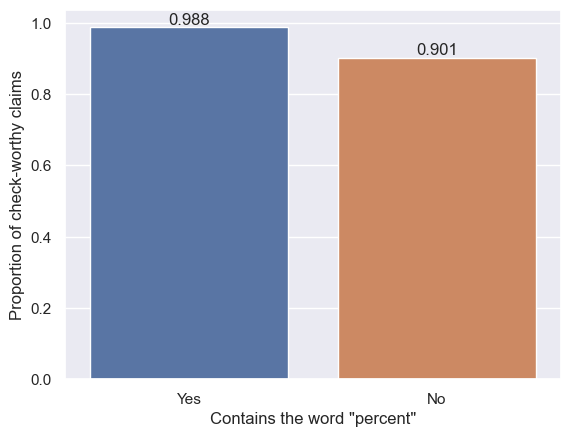

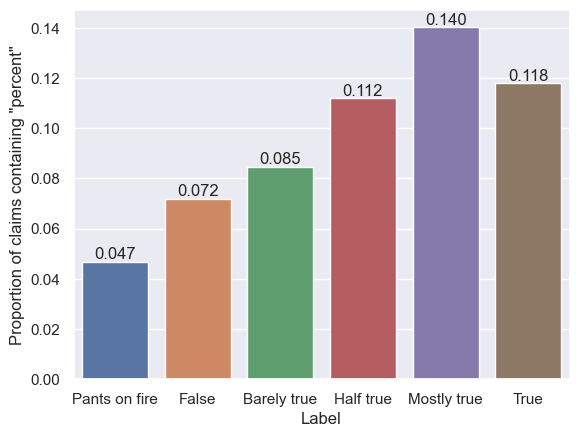

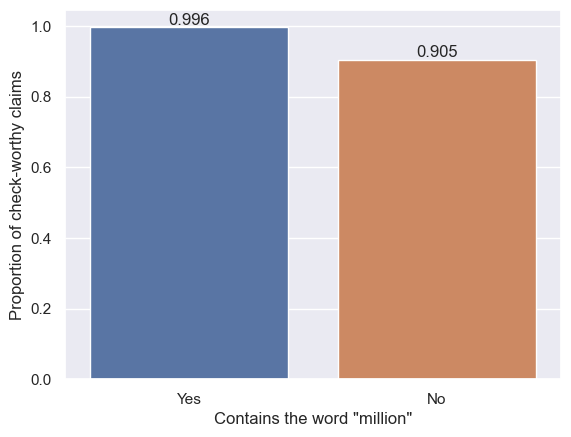

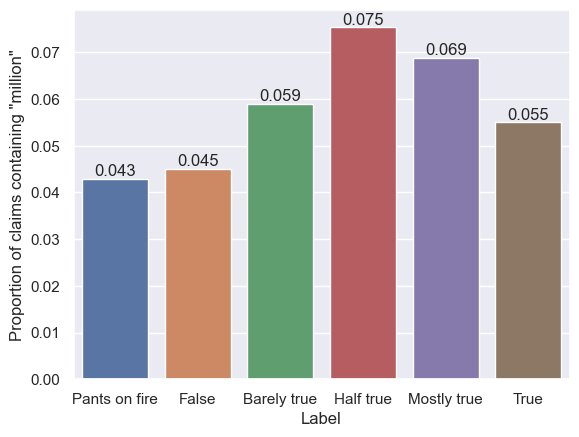

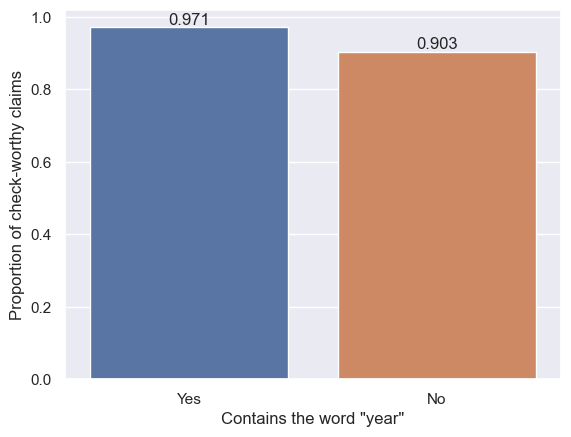

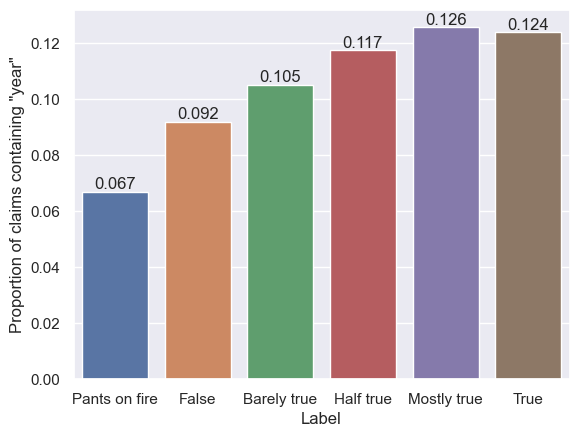

In [14]:
%autoreload

keywords = ["percent", "million", "year"]
os.makedirs("../figures/liar/keywords", exist_ok=True)
for keyword in keywords:
    contains_word = check_worthiness[check_worthiness["statement"].str.lower().str.contains(keyword)]
    not_contains_word = check_worthiness[~check_worthiness["statement"].str.lower().str.contains(keyword)]
    # Plot the proportion of check-worthy claims
    x = [f"Yes", f"No"]
    y = [contains_word["check_worthiness"].mean(), not_contains_word["check_worthiness"].mean()]
    show_bar_plot(
        x,
        y,
        xlabel=f"Contains the word \"{keyword}\"",
        ylabel="Proportion of check-worthy claims",
        y_ticks=[i*0.1 for i in range(11)],
        use_bar_labels=True,
        file_path=f"../figures/liar/keywords/{keyword}-checkworthiness.pdf",
        force_save=True
    )
    # Plot the proportion of claims within each label that uses the word
    x = [label_to_name(label) for label in LIARLabel]
    label_proportions = [
        (
            len(check_worthiness.query(f"label == {label.value} and statement.str.lower().str.contains('{keyword}')")) 
            / len(check_worthiness.query(f"label == {label.value}"))
        )
        for label in LIARLabel
    ]
    show_bar_plot(
        x,
        label_proportions,
        xlabel="Label",
        ylabel=f"Proportion of claims containing \"{keyword}\"",
        use_bar_labels=True,
        file_path=f"../figures/liar/keywords/{keyword}-labels.pdf",
        force_save=True
    )